In [1]:
import sys
import os
# Go three levels up from current file (i.e., from notebooks/ to project/)
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../..')))
import numpy as np
import matplotlib.pyplot as plt
import utils.mpl_pubstyle  # noqa: F401
import matplotlib.ticker as ticker


# Plot energy norm for IMEX-RB on 2D nonlinear problem
We show absolute stability of IMEX-RB

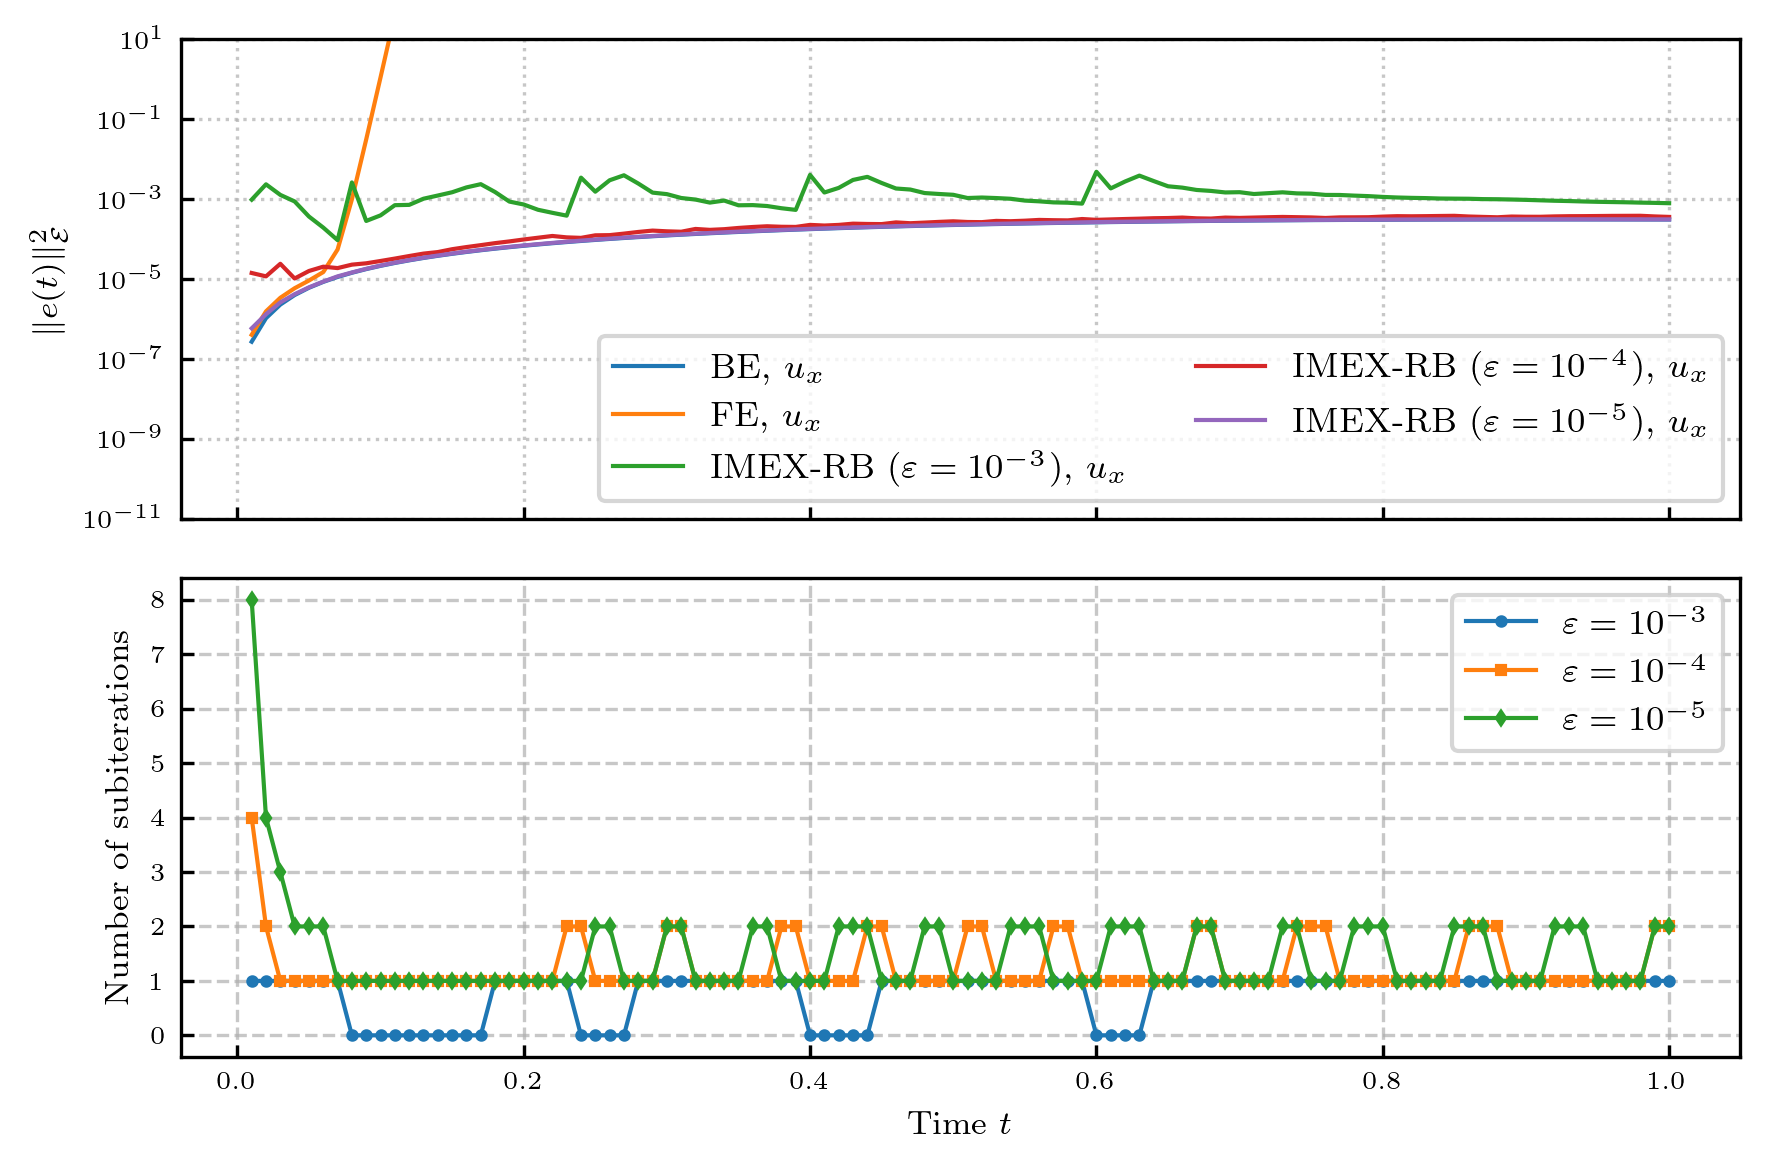

In [2]:
# Data
base_dir   = os.path.abspath(os.path.join(os.getcwd(), ''))
results_path = os.path.join(
    base_dir, os.pardir, os.pardir, 'results',
    'Burgers2D', 'energynorm', 'Test1', 'results.npz'
)
plots_dir  = os.path.join(base_dir, 'plots')
os.makedirs(plots_dir, exist_ok=True)

data = np.load(results_path, allow_pickle=True)
errors_energy = data['errors_energy'].item()   # dict: keys BE, FE, IMEX-RB
subiters      = data['subiters'].item()        # dict: key IMEX-RB
Nt            = int(data['Nt'])
tvec          = np.linspace(0, 1, Nt + 1)

methods      = ['BE', 'FE', 'IMEX-RB']
epsilon_values = data['epsilon_values']


comp_labels = ['u_x']  # or ['u_x','u_y'] if you have two
linestyles  = ['-', '--']
markers     = ['o', 's', 'd']  # one for each ε

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 4), sharex=True)

# Energy‐error subplot
for ic, comp in enumerate(comp_labels):
    # BE and FE are independent of ε (just one curve each)
    for m in ('BE', 'FE'):
        e = errors_energy[m][ic]
        ax1.semilogy(tvec[1:], e,
                     linestyle=linestyles[ic],
                     label=f'{m}, ${comp}$')

    # IMEX‐RB: one curve per ε
    for ie, eps in enumerate(epsilon_values):
        e = errors_energy['IMEX-RB'][ie, ic]
        expnt = int(np.log10(eps))
        ax1.semilogy(tvec[1:], e,
                     linestyle=linestyles[ic],
                     # marker=markers[ie],
                     # markevery=Nt//10,
                     label=rf'IMEX-RB $(\varepsilon=10^{{{expnt}}}),\,{comp}$')

ax1.set_ylabel(r'$\|e(t)\|_{\mathcal{E}}^2$')
ax1.set_ylim(1e-11, 1e1)
ax1.legend(fontsize='small', ncol=2)
ax1.grid(True, which='both', ls=':')

# Only IMEX-RB has subiters
for ie, eps in enumerate(epsilon_values):
    expnt = int(np.log10(eps))
    label = rf'$\varepsilon=10^{{{expnt}}}$'
    its = subiters['IMEX-RB'][ie]
    ax2.plot(tvec[1:], its,
             linestyle='-',
             marker=markers[ie],
             # markevery=Nt//10,
             label=label)

ax2.set_xlabel('Time $t$')
ax2.set_ylabel('Number of subiterations')
ax2.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
ax2.legend(fontsize='small')
ax2.grid(True)

plt.tight_layout()
out_file = os.path.join(plots_dir, 'Burgers2D_errors_subiters_eps.pdf')
plt.savefig(out_file)
plt.show()
plt.close()
